In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os

# Check if 'dataset1' directory exists, if not, download and unzip the dataset
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip

# Install required libraries: torch_snippets and pytorch_model_summary
!pip install -q torch_snippets pytorch_model_summary

# Import modules from torch_snippets, torchvision, and sklearn
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Import VGG16 model architecture with batch normalization from torchvision.models
from torchvision.models import vgg16_bn

# Import the tqdm library for displaying progress bars during iterations
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 109.9 MB/s et

## Wandb login

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Wandb configuration

In [14]:
class config:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  lr = 0.001 # learning rate
  epoch_num = 2

  # wandb config
  WANDB_CONFIG = {'_wandb_kernel': 'neuracort'}
  # initialize W&B
  run = wandb.init(
      project = "semantic_seg_unet_workshop",
      config = WANDB_CONFIG)

epoch,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.78622
train_loss,0.829
val_acc,0.78045
val_loss,0.88919


## Apply Transformation

In [5]:
def apply_transformation():
    """
    Returns a composition of image transformations commonly used in neural network training.
    Transforms:
    1. ToTensor(): Converts the image to a PyTorch tensor.
    2. Normalize(mean, std): Normalizes the tensor by subtracting the mean and dividing by the standard deviation
       along each channel. The provided mean and std correspond to the ImageNet dataset values.

    Returns:
    transforms.Compose: Composition of the specified transformations.
    """
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

## Dataset

In [6]:
class segmentationDataset(Dataset):

  # __init__: specifies the image location
  def __init__(self, split):
    self.split = split
    self.items = stems(f'dataset1/images_prepped_{split}')

  # __len__: define the length of the dataset.
  def __len__(self):
    return len(self.items)

  # __getitem__: loads an image and mask and resizes them to the same size
  def __getitem__(self, idx):
        # read data
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[idx]}.png', 1)
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[idx]}.png')
        # resize
        image = cv2.resize(image, (224,224))
        mask = cv2.resize(mask, (224,224))
        return image, mask

  # Randomly choose an item from the class instance
  def choose(self): return self[randint(len(self))]

  # Collate function for PyTorch DataLoader
  def collate_fn(self, batch):
      ims, masks = list(zip(*batch))

      ims = torch.cat([apply_transformation()(im.copy() / 255.)[None] for im in ims]).float().to(config.device)

      # Convert masks to grayscale if they have 3 channels
      masks = [mask[:, :, 0] if mask.shape[-1] == 3 else mask for mask in masks]

      # Transform and concatenate masks along a new dimension, convert to long tensor
      ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(config.device)

      return ims, ce_masks

## Dataloaders

In [7]:
def _dataloaders():
  # split dataset
  trainset = segmentationDataset('train')
  valset = segmentationDataset('test')
  # Print the size of the training and validation sets
  print(f"Training set size: {len(trainset)}")
  print(f"Validation set size: {len(valset)}")
  # dataloaders
  trainloader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=trainset.collate_fn)
  valloader = DataLoader(valset, batch_size=1, shuffle=True, collate_fn=valset.collate_fn )
  return trainloader, valloader

# call func
trainloader, valloader = _dataloaders()

Training set size: 367

Validation set size: 101

## U-Net Architecture

### Define U-Net blocks

In [8]:
# define convolution block
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
# define up-convolution block
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

### Dfine U-Net class

In [9]:
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()


        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])


        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)


        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)


        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)


        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)


        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)


        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)


        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)


        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)


        x = self.conv11(x)


        return x

## Loss Function

In [10]:
loss_func = nn.CrossEntropyLoss()
def UNetLoss(preds, labels):
    """
    Compute the U-Net loss using a specified loss function and accuracy.

    Args:
    - preds (torch.Tensor): Predictions from the model.
    - labels (torch.Tensor): Ground truth labels.
    - loss_func (torch.nn.Module): Loss function (e.g., nn.CrossEntropyLoss).

    Returns:
    - Tuple[torch.Tensor, torch.Tensor]: Loss and accuracy.
    """
    loss = loss_func(preds, labels)
    accuracy = (torch.max(preds, 1)[1] == labels).float().mean()
    return loss, accuracy

## Training & Validation

In [11]:
class engine():
  def train_batch(model, data, optimizer, criterion):
      """
      Train the model for one batch.

      Args:
      - model (torch.nn.Module): The neural network model.
      - data (Tuple[torch.Tensor, torch.Tensor]): Tuple containing input images (ims) and ground truth masks (ce_masks).
      - optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
      - criterion: Loss and accuracy computation function.

      Returns:
      - Tuple[float, float]: Training loss and accuracy for the batch.
      """
      # Set the model to training mode
      model.train()
      # unpack/unzip input data
      ims, ce_masks = data
      ce_masks = ce_masks.long()
      # print(ce_masks.shape)
      # Forward pass
      _masks = model(ims)
      # print(_masks.shape)
      # zero the gradients
      optimizer.zero_grad()
      # compute loss and accuracy
      loss, acc = criterion(_masks, ce_masks)
      # Backward pass and optimization (update weights)
      loss.backward()
      optimizer.step()
      return loss.item(), acc.item()

  @torch.no_grad()
  def validate_batch(model, data, criterion):
      """
      Validate the model for one batch.

      Args:
      - model (torch.nn.Module): The neural network model.
      - data (Tuple[torch.Tensor, torch.Tensor]): Tuple containing input images (ims) and ground truth masks (masks).
      - criterion: Loss and accuracy computation function.

      Returns:
      - Tuple[float, float]: Validation loss and accuracy for the batch.
      """
      # set the model to evaluation mode
      model.eval()
      # unzip input data
      ims, ce_masks = data
      ce_masks = ce_masks.long()
      # forward pass
      masks = model(ims)
      # compute loss and accuracy
      loss, acc = criterion(masks, ce_masks)

      return loss.item(), acc.item()

## Define the model

In [12]:
def define_model():
    """
    Define and initialize the U-Net model, loss criterion, and optimizer.

    Returns:
    - Tuple[torch.nn.Module, Callable, torch.optim.Optimizer]:
      U-Net model, loss criterion, and optimizer.
    """
    # U-Net defined architecture
    model = UNet().to(config.device)
    # loss function
    criterion = UNetLoss
    # define model hyperparamters
    optimizer = optim.Adam(model.parameters(), lr=config.lr)

    return model, criterion, optimizer

# call func
model, criterion, optimizer = define_model()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:11<00:00, 49.1MB/s]


## Launch Training!

In [13]:
def run():
    """
    Main training loop for the U-Net model.

    Iterates through epochs, performs training and validation,
    and logs metrics using Weights & Biases.
    """
    for epoch in range(config.epoch_num):
        print("####################")
        print(f"       Epoch: {epoch}   ")
        print("####################")

        # Training loop
        for bx, data in tqdm(enumerate(trainloader), total=len(trainloader)):
            # Perform training for a batch and retrieve loss and accuracy
            train_loss, train_acc = engine.train_batch(model, data, optimizer, criterion)

        # Validation loop
        for bx, data in tqdm(enumerate(valloader), total=len(valloader)):
            # Perform validation for a batch and retrieve loss and accuracy
            val_loss, val_acc = engine.validate_batch(model, data, criterion)

        # Log metrics using Weights & Biases
        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })
        print()
# call func
run()

####################

Epoch: 0

####################

100%|██████████| 101/101 [00:02<00:00, 42.30it/s]


## Visualize Predictions

In [15]:
def save_table():

  for bx, data in tqdm(enumerate(valloader), total = len(valloader)):
    im, mask = data
    _mask = model(im)
    _, _mask = torch.max(_mask, dim=1)


    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0])
    plt.savefig("original_image.jpg")
    plt.close()


    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])
    plt.savefig("original_mask.jpg")
    plt.close()


    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0])
    plt.savefig("predicted_mask.jpg")
    plt.close()


    table.add_data(
        wandb.Image(cv2.cvtColor(cv2.imread("original_image.jpg"), cv2.COLOR_BGR2RGB)),
        wandb.Image(cv2.cvtColor(cv2.imread("original_mask.jpg"), cv2.COLOR_BGR2RGB)),
        wandb.Image(cv2.cvtColor(cv2.imread("predicted_mask.jpg"), cv2.COLOR_BGR2RGB))
    )
  wandb.log({table_name: table})


save_table("Predictions")

TypeError: save_table() takes 0 positional arguments but 1 was given

  0%|          | 0/101 [00:00<?, ?it/s]

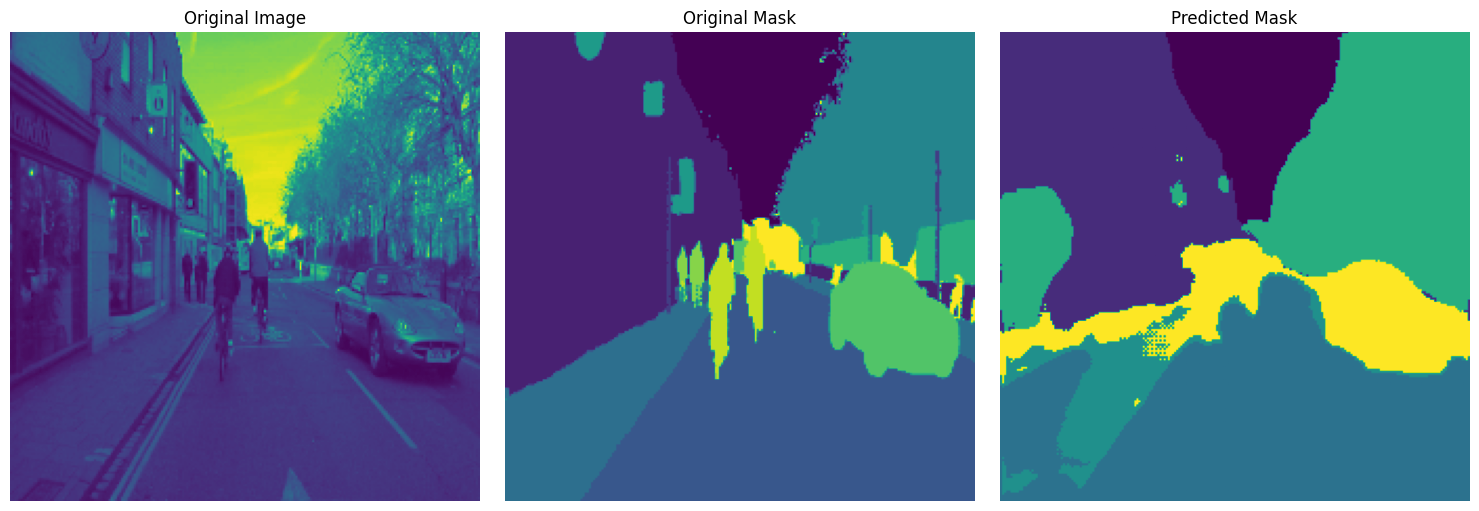

  1%|          | 1/101 [00:00<00:57,  1.75it/s]

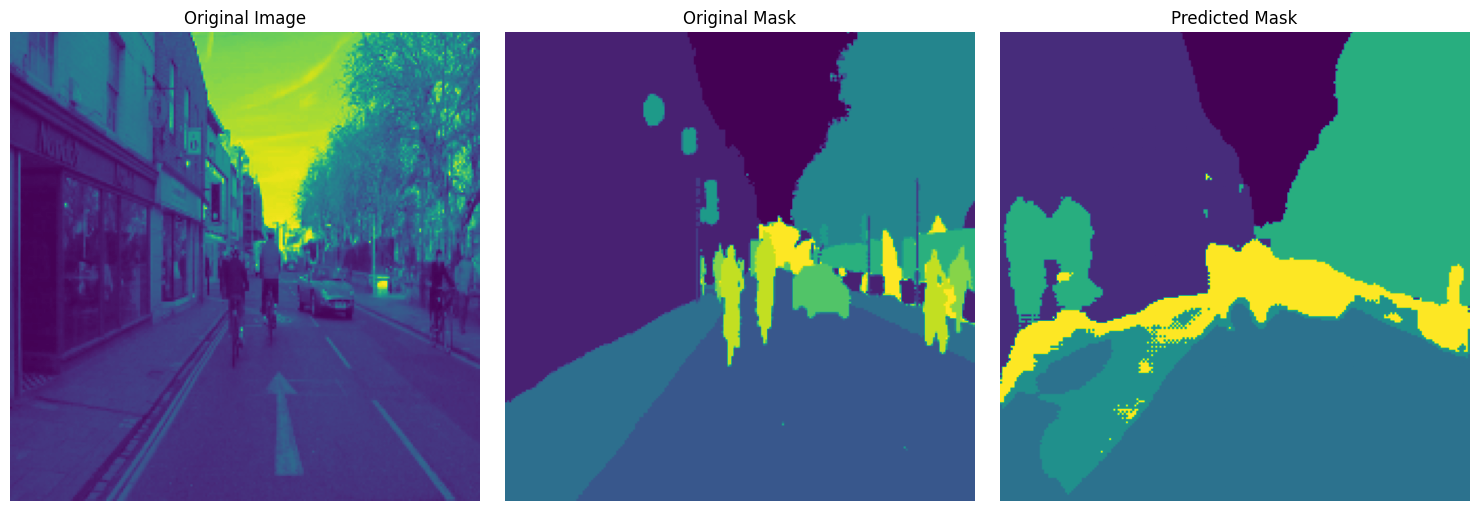

  2%|▏         | 2/101 [00:01<00:54,  1.82it/s]

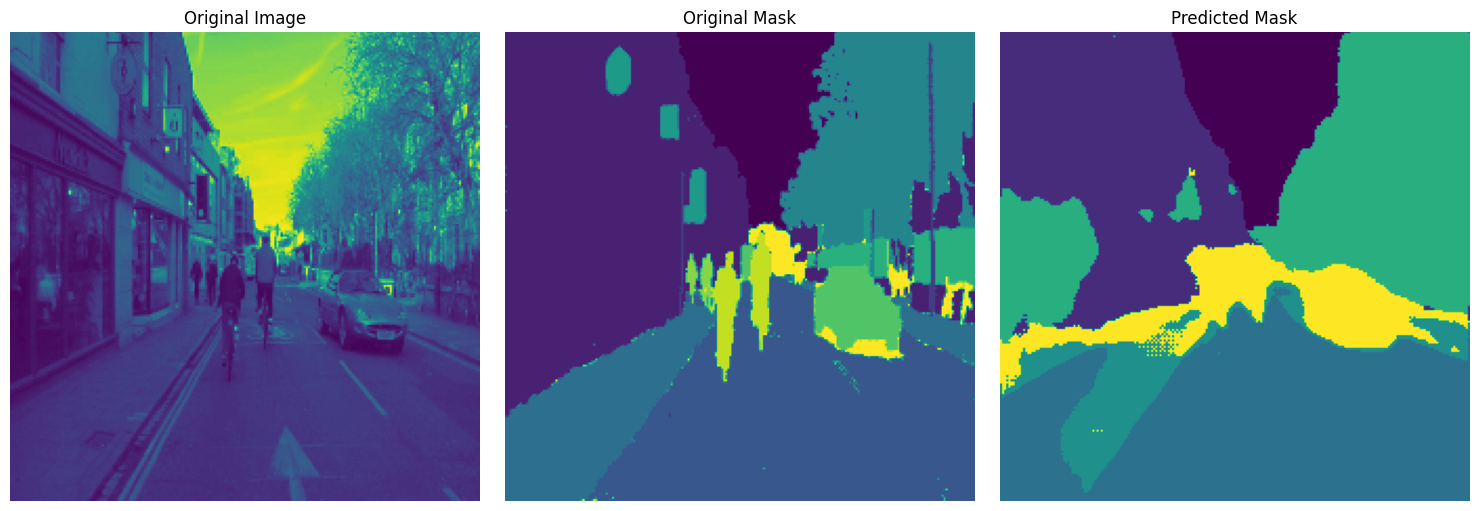

  3%|▎         | 3/101 [00:01<00:52,  1.87it/s]

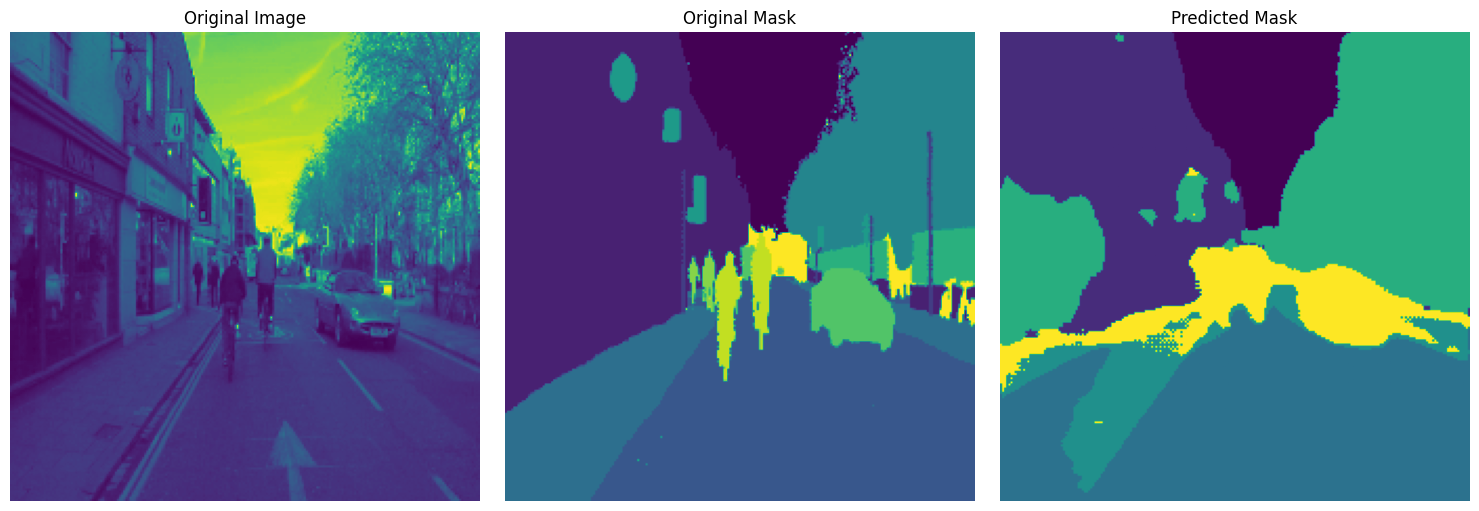

  4%|▍         | 4/101 [00:02<00:51,  1.89it/s]

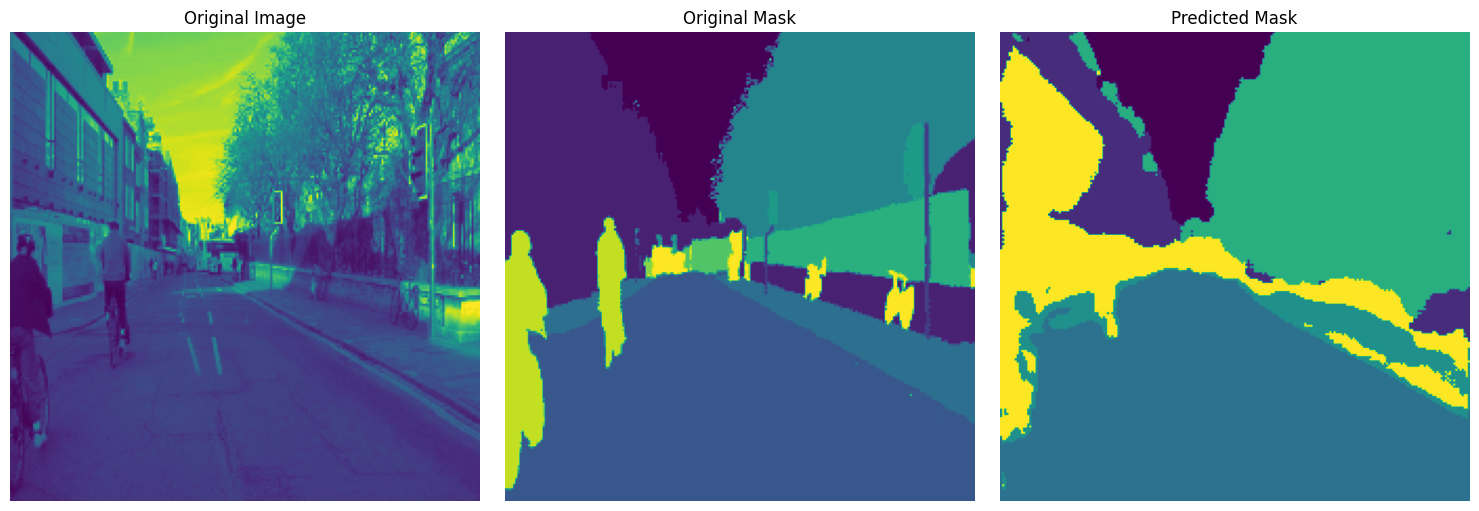

  5%|▍         | 5/101 [00:02<00:51,  1.85it/s]


In [16]:
import matplotlib.pyplot as plt
from IPython.display import display, Image

def visualisation():

    count = 0
    for bx, data in tqdm(enumerate(valloader), total=len(valloader)):
        if count >= 5:
            break  # Stop after showing 5 examples

        im, mask = data
        _mask = model(im)
        _, _mask = torch.max(_mask, dim=1)

        # Save and display original image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(im[0].permute(1, 2, 0).detach().cpu()[:, :, 0])
        plt.title("Original Image")
        plt.axis("off")

        # Save and display original mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1, 2, 0).detach().cpu()[:, :, 0])
        plt.title("Original Mask")
        plt.axis("off")

        # Save and display predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(_mask.permute(1, 2, 0).detach().cpu()[:, :, 0])
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        count += 1 # Increment the count
# call func
visualisation()